In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

launch.json used to generate epoch-wise pkls

In [ ]:
# {
#     "version": "0.2.0",
#     "configurations": [
#    	 {
#    		 "name": "Run with argument",
#    		 "type": "python",
#    		 "request": "launch",
#    		 "program": "${file}",
#    		 "console": "integratedTerminal",
#    		 "cwd": "${workspaceFolder}/tools",
#    		 "env": {"CUDA_VISIBLE_DEVICES": "1"},
#    		 "args": ["--cfg_file" ,
#            		 "cfgs/kitti_models/pv_rcnn_ssl_60.yaml",
#            		 "--split",
#            		 "train_0.01_1",
#            		 "--batch_size",
#            		 "8",
#            		 "--ckpt_save_interval",
#            		 "20",
#            		 "--repeat",
#            		 "5",
#            		 "--fix_random_seed",
#            		 "--extra_tag",
#            		 "tsne_3diou_secndstage_ckpt60_snapshot_new_ulbloader",
#            		 "--dbinfos",
#            		 "kitti_dbinfos_train_0.01_1_37.pkl",
#                  "--epochs", // for repeat 5, bsz 8: to cover 3769 ulb frames needs ~21 epochs
#                  "100",
#                  "--ckpt",
#                  "/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/ckpts_3diou_split_1_1_0fbd0d1/ckpt/checkpoint_epoch_60.pth",
#                 "--set",
#                  "MODEL.STORE_SCORES_IN_PKL",
#                 "True"
#    		 ],
#    	 }
#     ]
# }


Script to read epoch wise pkls, combine and store as ckptX_snapshot_data

In [2]:
import os
import pickle
# Directory containing the pickle files
pickle_dir = "/mnt/data/adat01/adv_OpenPCDet/output/kitti_models/pv_rcnn_ssl_60/tsne_3diou_secndstage_ckpt60_snapshot_new_ulbloader_97a7024/"

# List all pickle files in the directory
pickle_files = [file for file in os.listdir(pickle_dir) if file.endswith(".pkl")]

# Initialize an empty dictionary to store aggregated data
ckpt60_snapshot_data = {}

# Iterate over each pickle file
for file in pickle_files:
    # Load the pickle file
    with open(os.path.join(pickle_dir, file), "rb") as f:
        data = pickle.load(f)
    # Combine the data from the current file with the aggregated data
    for key, value in data.items():
        if key not in ckpt60_snapshot_data:
            ckpt60_snapshot_data[key] = []
        ckpt60_snapshot_data[key].extend(value)


In [3]:
ckpt60_snapshot_data.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'obj_scores', 'gt_boxes', 'assigned_gt_inds', 'assigned_iou_class', 'roi_scores', 'num_points_in_roi', 'class_labels', 'iteration', 'shared_features', 'frame_id', 'shared_features_gt', 'instance_idx', 'labeled_mask', 'unlabeled_mask', 'ori_gt_boxes', 'assigned_pl_inds', 'assigned_iou_pl_class', 'gt_obj_scores'])

In [4]:
ckpt60_snapshot_data.keys()
import numpy as np

# print(" Total number of iterations", ckpt20_snapshot_data['iteration'][-1])
# Convert the lists to numpy arrays for boolean indexing
labeled_mask_np = np.array(ckpt60_snapshot_data['labeled_mask'])
frame_id_np = np.array(ckpt60_snapshot_data['frame_id'])

# Use boolean indexing to filter frame_id where labeled_mask == 0
lb_frame_ids = frame_id_np[labeled_mask_np == 1]
print(len(lb_frame_ids))

ulb_frame_ids = frame_id_np[labeled_mask_np == 0]
print(len(ulb_frame_ids))
print(np.unique(lb_frame_ids).shape)
print(np.unique(ulb_frame_ids).shape)

7176
7176
(37,)
(3142,)


In [5]:
vals,indices = np.unique(ulb_frame_ids,return_index=True)
print(len(np.sort(indices)))
unique_ulb_frame_mask = np.sort(indices)

3142


In [6]:
ulb_obj_scores = np.array(ckpt60_snapshot_data['obj_scores'])
print(len(ulb_obj_scores))
ulb_obj_scores = ulb_obj_scores[unique_ulb_frame_mask]

1435200


In [7]:
ulb_iou_roi_pl = np.array(ckpt60_snapshot_data['iou_roi_pl'])
print(len(ulb_iou_roi_pl))
ulb_iou_roi_pl = ulb_iou_roi_pl[unique_ulb_frame_mask]

1387500


In [8]:
ulb_iou_roi_gt = np.array(ckpt60_snapshot_data['iou_roi_gt'])
print(len(ulb_iou_roi_gt))
ulb_iou_roi_gt = ulb_iou_roi_gt[unique_ulb_frame_mask]

1429600


In [9]:
ulb_roi_scores = np.array(ckpt60_snapshot_data['roi_scores'])
print(len(ulb_roi_scores))
ulb_roi_scores = ulb_roi_scores[unique_ulb_frame_mask]

1435200


In [10]:
ulb_shared_features = np.array(ckpt60_snapshot_data['shared_features'])
print(len(ulb_shared_features))
ulb_shared_features = ulb_shared_features[unique_ulb_frame_mask]

ulb_roi_class_labels = np.array(ckpt60_snapshot_data['class_labels'])
print(len(ulb_roi_class_labels))
ulb_roi_class_labels = ulb_roi_class_labels[unique_ulb_frame_mask]

1435200
1435200


In [11]:
ulb_shared_features_gt = np.array(ckpt60_snapshot_data['shared_features_gt'])
ulb_shared_features_gt = ulb_shared_features_gt[unique_ulb_frame_mask]
print(len(ulb_shared_features_gt))

ulb_ori_gt_boxes = np.array(ckpt60_snapshot_data['ori_gt_boxes'])
ulb_ori_gt_classes = ulb_ori_gt_boxes[:,-1]
ulb_ori_gt_classes = ulb_ori_gt_classes[unique_ulb_frame_mask]
print(len(ulb_ori_gt_classes))

ulb_gt_conf_scores = np.array(ckpt60_snapshot_data['gt_obj_scores'])
ulb_gt_conf_scores = ulb_gt_conf_scores[unique_ulb_frame_mask]
print(len(ulb_gt_conf_scores))

3142
3142
3142


##### TsNE plotting below ####


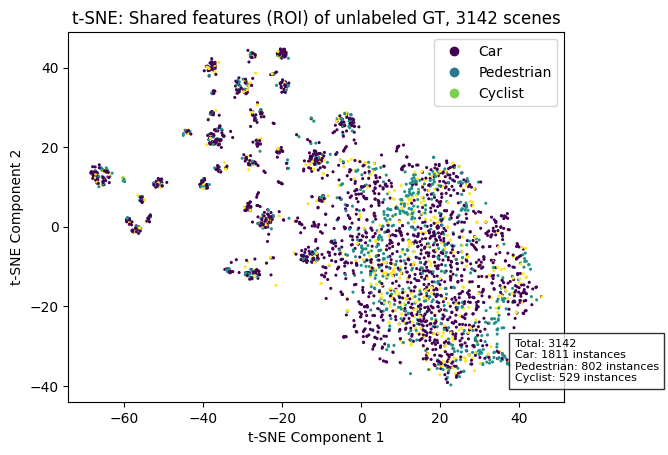

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_shared_features_gt
y = ulb_ori_gt_classes.astype(int)
conf_scores = ulb_gt_conf_scores
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"t-SNE: Shared features (ROI) of unlabeled GT, {np.unique(ulb_frame_ids).shape[0]} scenes"
plt.title(title)

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

In [103]:
# util function for getting TP/FP for objectness-gt-ulb
x = ulb_shared_features_gt
y = ulb_ori_gt_classes.astype(int)
conf_scores = ulb_gt_conf_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])

def get_objectness_tp_fp(x_tsne, y_tsne, conf_scores,thresh):
    unique_classes = np.unique(y_tsne)
    x_tsne_dict = {}
    y_pred_dict = {}

    for class_label in unique_classes:
        class_mask = y_tsne == class_label
        x_tsne_class = np.zeros_like(x_tsne)
        x_tsne_class[class_mask] = x_tsne[class_mask]
        x_tsne_dict[class_label] = x_tsne_class

        tmp = np.zeros_like(conf_scores)
        tmp = conf_scores * class_mask 
        tmp = tmp >= gt_iou_thresh[class_label]
        y_pred_dict[class_label] = tmp

    return x_tsne_dict, y_pred_dict

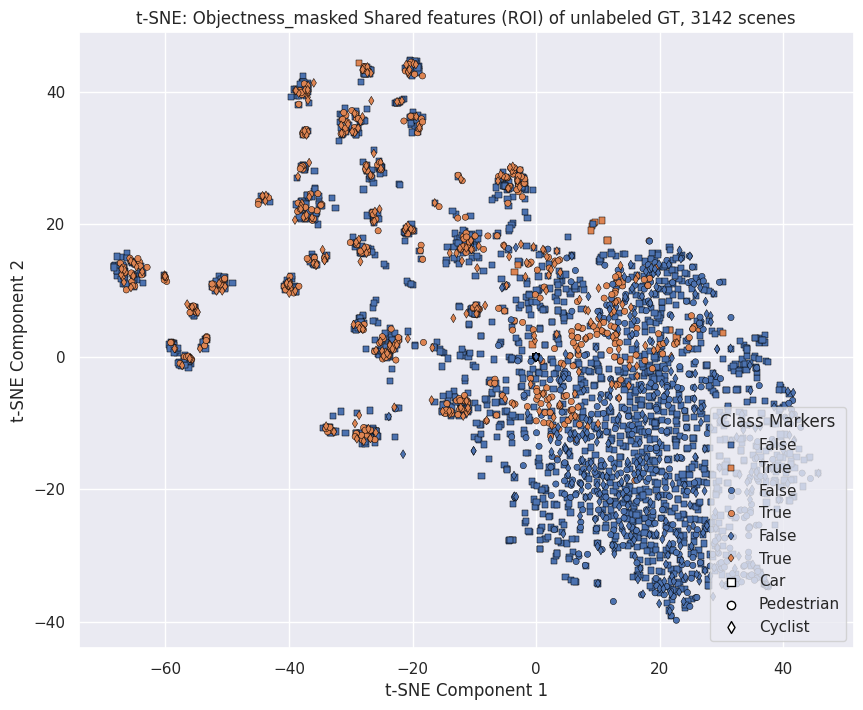

In [131]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_shared_features_gt
y = ulb_ori_gt_classes.astype(int)
conf_scores = ulb_gt_conf_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
x_tsne_dict, y_tsne_dict = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)
tp_fp_labels = y_tsne_dict[0] + y_tsne_dict[1] + y_tsne_dict[2] 
# tp_fp_labels[tp_fp_labels] = 'TP'
# tp_fp_labels[~tp_fp_labels] = 'FP'
# Set seaborn style
sns.set(style='darkgrid')

# Define marker styles
markers = ["s","o","d"]


plt.figure(figsize=(10, 8))
# Plot t-SNE components
start=0
while start < 3:
    sns.scatterplot(x = x_tsne_dict[start][:, 0], y = x_tsne_dict[start][:, 1], marker = markers[start], s = 20, edgecolor = 'black', hue = tp_fp_labels, legend= True)
    start+=1


# Set labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"t-SNE: Objectness_masked Shared features (ROI) of unlabeled GT, {np.unique(ulb_frame_ids).shape[0]} scenes"
plt.title(title)

class_names = ['Car', 'Pedestrian', 'Cyclist']
# Plot dummy points with markers
for marker, class_name in zip(markers, class_names):
    plt.scatter([], [], marker=marker, color='white', label=class_name,edgecolor = 'black')  # Set color to white
# Create legend
plt.legend(title='Class Markers', loc='lower right')  # Move legend to bottom right



# Show plot
plt.show()


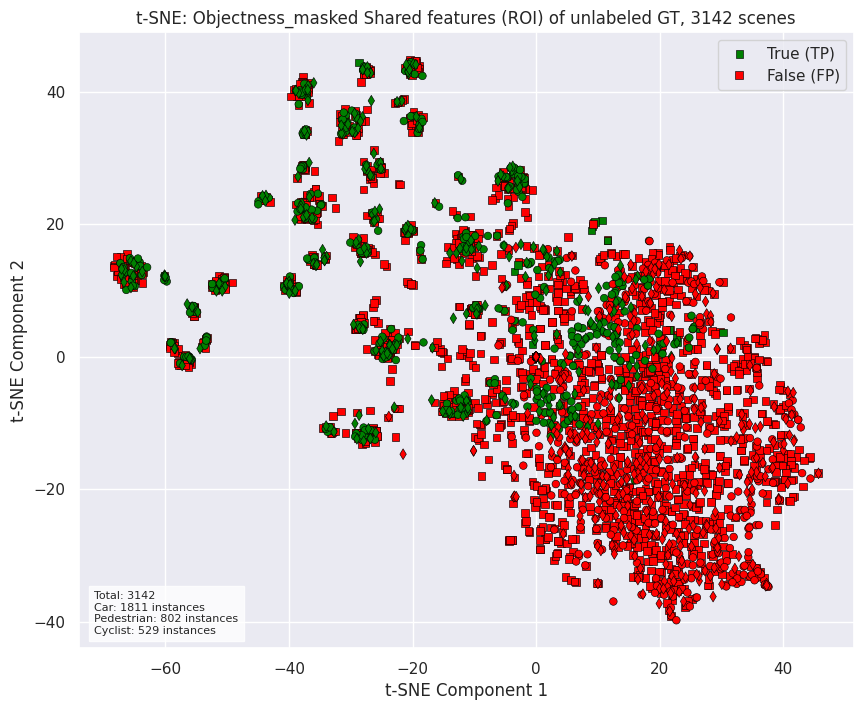

In [146]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_shared_features_gt
y = ulb_ori_gt_classes.astype(int)
conf_scores = ulb_gt_conf_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
x_tsne_dict, y_tsne_dict = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)
tp_fp_labels = y_tsne_dict[0] + y_tsne_dict[1] + y_tsne_dict[2]

# Set seaborn style
sns.set(style='darkgrid')

# Define marker styles
markers = ["s", "o", "d"]

plt.figure(figsize=(10, 8))

# Plot t-SNE components
for start, marker in enumerate(markers):
    sns.scatterplot(
        x=x_tsne_dict[start][:, 0],
        y=x_tsne_dict[start][:, 1],
        marker=marker,
        s=30,
        edgecolor='black',
        hue=tp_fp_labels,
        palette={True: 'green', False: 'red'},  # Bind colors to True and False
        legend='full'  # Show legend
    )

# Set labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"t-SNE: Objectness_masked Shared features (ROI) of unlabeled GT, {np.unique(ulb_frame_ids).shape[0]} scenes"
plt.title(title)

# Plot dummy points with markers for class names
class_names = ['Car', 'Pedestrian', 'Cyclist']
for marker, class_name in zip(markers, class_names):
    plt.scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

# Create legend for class names
plt.legend(title='Class Markers', loc='lower right')  # Move legend to bottom right

# Create separate legend for True (TP) and False (FP)
plt.legend(['True (TP)', 'False (FP)'], loc='upper right')

class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.02, 0.02, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))
# Show plot
plt.show()


In [ ]:
# def get_max_iou(anchors, gt_boxes, gt_classes, matched_threshold=0.6):
#     num_anchors = anchors.shape[0]
#     num_gts = gt_boxes.shape[0]

#     ious = torch.zeros((num_anchors,), dtype=torch.float, device=anchors.device)
#     labels = torch.ones((num_anchors,), dtype=torch.int64, device=anchors.device) * -1
#     gt_to_anchor_max = torch.zeros((num_gts,), dtype=torch.float, device=anchors.device)

#     if len(gt_boxes) > 0 and anchors.shape[0] > 0:
#         anchor_by_gt_overlap = iou3d_nms_utils.boxes_iou3d_gpu(anchors[:, 0:7], gt_boxes[:, 0:7])
#         gt_to_anchor_max = anchor_by_gt_overlap.max(dim=0)[0]
#         anchor_to_gt_argmax = anchor_by_gt_overlap.argmax(dim=1)
#         anchor_to_gt_max = anchor_by_gt_overlap[torch.arange(num_anchors, device=anchors.device), anchor_to_gt_argmax]

#         pos_inds = anchor_to_gt_max >= matched_threshold
#         gt_inds_over_thresh = anchor_to_gt_argmax[pos_inds]
#         labels[pos_inds] = gt_classes[gt_inds_over_thresh]
#         ious[:] = anchor_to_gt_max

#     return ious, labels, gt_to_anchor_max

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

# # Create a sample dataset
# x = selected_sh_gt.cpu().numpy()
# y_gt = selected_gt_classes.cpu().numpy().astype(int)

# # Normalize the features
# scaler = StandardScaler()
# x_normalized = scaler.fit_transform(x)

# # Perform t-SNE on normalized features
# tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
# x_tsne_gt = tsne.fit_transform(x_normalized)

# # Create a scatter plot with colored points based on labels
# scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_gt, cmap='viridis', s=1.5)
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.title('t-SNE : Shared features(GT), end of Pretrain, 3dioumatch-org')

# # Add legend
# class_names = ['Car', 'Pedestrian', 'Cyclist']
# handles, _ = scatter.legend_elements(num=np.unique(y_gt))
# legend = plt.legend(handles, class_names, loc='upper right')

# # Add a box showing occurrences of each class
# class_counts = np.bincount(y_gt)
# total_count = np.sum(class_counts)
# class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
# occurrences_text = '\n'.join(class_counts_str)
# plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# plt.show()


In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# # Plot the first t-SNE plot
# scatter1 = axs[0].scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
# axs[0].set_xlabel('t-SNE Component 1')
# axs[0].set_ylabel('t-SNE Component 2')
# axs[0].set_title('t-SNE : Shared features ROI, end of Pretrain, 3dioumatch-org')

# # Plot the second t-SNE plot
# scatter2 = axs[1].scatter(x_tsne_gt[:, 0], x_tsne_gt[:, 1], c=y_gt, cmap='viridis', s=1.5)
# axs[1].set_xlabel('t-SNE Component 1')
# axs[1].set_ylabel('t-SNE Component 2')
# axs[1].set_title('t-SNE : Shared features GT, end of Pretrain, 3dioumatch-org')

# class_counts = np.bincount(y)
# total_count = np.sum(class_counts)
# class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
# occurrences_text = '\n'.join(class_counts_str)
# plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))


# class_counts = np.bincount(y_gt)
# total_count = np.sum(class_counts)
# class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
# occurrences_text = '\n'.join(class_counts_str)
# plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# # Set equal aspect ratio for both plots
# axs[0].axis('equal')
# axs[1].axis('equal')

# plt.show()